<a href="https://colab.research.google.com/github/HR-HBM/BME-Code-files/blob/main/DR_Detection_Model_(DenseNet121_%26_RSG_Net).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU)
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import files
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Parameters
IMG_SIZE = 512
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 5  # ICDR levels 0-4



# Data paths
train_dir = "/content/drive/MyDrive/DiabeticRetinopathy/train"
val_dir = "/content/drive/MyDrive/DiabeticRetinopathy/validate"
test_dir = "/content/drive/MyDrive/DiabeticRetinopathy/test"


class_weight_dict = {
    0: 0.6,
    1: 10.0,
    2: 5.0,
    3: 13.0,
    4: 5.0
}

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=[0.5, 1.5],
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3423 images belonging to 5 classes.
Found 732 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [ ]:
# Model architecture
def create_dr_model():

  base_model = DenseNet121(
      weights='imagenet',
      include_top=False,
      input_shape=(IMG_SIZE, IMG_SIZE, 3)
  )


  # Build the model
  model = models.Sequential([
      base_model,
      layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.GlobalAveragePooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.1),
      layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  # Compile the model
  model.compile(
      optimizer=optimizers.Adam(learning_rate=0.0001),
      loss='categorical_crossentropy',
      metrics=['accuracy',
               tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall'),
               tf.keras.metrics.AUC(name='auc'),
               tf.keras.metrics.F1Score(name='f1_score')]

    )

  return model

# Create the model
model = create_dr_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 16, 16, 1024)   │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 32)     │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,451,717 (28.43 MB)

 Trainable params: 7,367,813 (28.11 MB)

 Non-trainable params: 83,904 (327.75 KB)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(
    'rsg_net_V3drModel.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-4,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weight_dict,  #class weights
    verbose=1
)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2231 - auc: 0.5381 - f1_score: 0.1628 - loss: 3.7063 - precision: 0.2338 - recall: 0.0594
Epoch 1: val_accuracy improved from -inf to 0.73361, saving model to rsg_net_V3drModel.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - accuracy: 0.2231 - auc: 0.5382 - f1_score: 0.1628 - loss: 3.7034 - precision: 0.2339 - recall: 0.0593 - val_accuracy: 0.7336 - val_auc: 0.8977 - val_f1_score: 0.2973 - val_loss: 1.4744 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2761 - auc: 0.6048 - f1_score: 0.1930 - loss: 3.1896 - precision: 0.3400 - recall: 0.0666
Epoch 2: val_accuracy did not improve from 0.73361
107/107 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.2764 - auc: 0.6051 - f1_score: 0.1932 - loss: 3.1882 - precision: 0.3405 - recall: 0.0667 - val_accuracy: 0.3852 - val_auc: 0.8186 - val_f1_score: 0.3168 - val_loss: 1.2876 - val_precision: 1.0000 - val_recall: 0.0041 - learning_rate: 1.0000e-04
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3568 - auc: 0.7096 - f1_score: 0.2719 - loss: 2.7806 - precision: 0.4260 - recall: 0.1043
Epoch 3: val_accuracy did

107/107 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.6299 - auc: 0.8757 - f1_score: 0.5248 - loss: 1.6461 - precision: 0.6837 - recall: 0.4564 - val_accuracy: 0.7978 - val_auc: 0.9374 - val_f1_score: 0.5298 - val_loss: 0.6725 - val_precision: 0.8316 - val_recall: 0.7555 - learning_rate: 1.0000e-04
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6472 - auc: 0.8898 - f1_score: 0.5321 - loss: 1.6524 - precision: 0.7047 - recall: 0.5465
Epoch 11: val_accuracy did not improve from 0.79781
107/107 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.6474 - auc: 0.8898 - f1_score: 0.5322 - loss: 1.6533 - precision: 0.7048 - recall: 0.5466 - val_accuracy: 0.6243 - val_auc: 0.8811 - val_f1_score: 0.4447 - val_loss: 0.9767 - val_precision: 0.6684 - val_recall: 0.5287 - learning_rate: 1.0000e-04
Epoch 12/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6562 - auc: 0.8899 - f1_score: 0.5341 - loss: 1.7522 - precision: 0.7334 - recall: 0.5420
Epoch 12: val_accuracy did not

107/107 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.6790 - auc: 0.8940 - f1_score: 0.5538 - loss: 1.6072 - precision: 0.7291 - recall: 0.5870 - val_accuracy: 0.8060 - val_auc: 0.9425 - val_f1_score: 0.5595 - val_loss: 0.6525 - val_precision: 0.8353 - val_recall: 0.7691 - learning_rate: 1.0000e-04
Epoch 14/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7297 - auc: 0.9157 - f1_score: 0.6065 - loss: 1.4474 - precision: 0.7870 - recall: 0.6417
Epoch 14: val_accuracy did not improve from 0.80601
107/107 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.7295 - auc: 0.9157 - f1_score: 0.6064 - loss: 1.4478 - precision: 0.7868 - recall: 0.6417 - val_accuracy: 0.7869 - val_auc: 0.9367 - val_f1_score: 0.5794 - val_loss: 0.6945 - val_precision: 0.8170 - val_recall: 0.7623 - learning_rate: 1.0000e-04
Epoch 15/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7535 - auc: 0.9241 - f1_score: 0.6308 - loss: 1.2699 - precision: 0.8015 - recall: 0.6840
Epoch 15: val_accuracy improve

107/107 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.7535 - auc: 0.9242 - f1_score: 0.6308 - loss: 1.2699 - precision: 0.8015 - recall: 0.6840 - val_accuracy: 0.8142 - val_auc: 0.9442 - val_f1_score: 0.4886 - val_loss: 0.6263 - val_precision: 0.8333 - val_recall: 0.7923 - learning_rate: 1.0000e-04
Epoch 16/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7476 - auc: 0.9283 - f1_score: 0.6437 - loss: 1.2270 - precision: 0.7989 - recall: 0.6714
Epoch 16: val_accuracy did not improve from 0.81421
107/107 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.7477 - auc: 0.9283 - f1_score: 0.6437 - loss: 1.2270 - precision: 0.7989 - recall: 0.6716 - val_accuracy: 0.8005 - val_auc: 0.9485 - val_f1_score: 0.4968 - val_loss: 0.6167 - val_precision: 0.8211 - val_recall: 0.7773 - learning_rate: 1.0000e-04
Epoch 17/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7746 - auc: 0.9379 - f1_score: 0.6416 - loss: 1.3668 - precision: 0.8191 - recall: 0.7075
Epoch 17: val_accuracy did not

107/107 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.8004 - auc: 0.9488 - f1_score: 0.6740 - loss: 1.0077 - precision: 0.8370 - recall: 0.7551 - val_accuracy: 0.8497 - val_auc: 0.9632 - val_f1_score: 0.5458 - val_loss: 0.5118 - val_precision: 0.8583 - val_recall: 0.8361 - learning_rate: 1.0000e-04
Epoch 21/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8165 - auc: 0.9557 - f1_score: 0.7239 - loss: 0.8226 - precision: 0.8418 - recall: 0.7781
Epoch 21: val_accuracy did not improve from 0.84973
107/107 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.8165 - auc: 0.9556 - f1_score: 0.7238 - loss: 0.8227 - precision: 0.8418 - recall: 0.7781 - val_accuracy: 0.7801 - val_auc: 0.9326 - val_f1_score: 0.5029 - val_loss: 0.7297 - val_precision: 0.8026 - val_recall: 0.7664 - learning_rate: 1.0000e-04
Epoch 22/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8169 - auc: 0.9530 - f1_score: 0.7243 - loss: 0.7979 - precision: 0.8462 - recall: 0.7813
Epoch 22: val_accuracy did not

107/107 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.8371 - auc: 0.9662 - f1_score: 0.7506 - loss: 0.7643 - precision: 0.8636 - recall: 0.7925 - val_accuracy: 0.8634 - val_auc: 0.9424 - val_f1_score: 0.5091 - val_loss: 0.6098 - val_precision: 0.8710 - val_recall: 0.8579 - learning_rate: 1.0000e-04
Epoch 24/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8567 - auc: 0.9692 - f1_score: 0.7627 - loss: 0.7193 - precision: 0.8777 - recall: 0.8251
Epoch 24: val_accuracy did not improve from 0.86339
107/107 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.8566 - auc: 0.9692 - f1_score: 0.7625 - loss: 0.7199 - precision: 0.8776 - recall: 0.8250 - val_accuracy: 0.8265 - val_auc: 0.9440 - val_f1_score: 0.5538 - val_loss: 0.6388 - val_precision: 0.8446 - val_recall: 0.8169 - learning_rate: 1.0000e-04
Epoch 25/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8414 - auc: 0.9664 - f1_score: 0.7495 - loss: 0.9375 - precision: 0.8629 - recall: 0.8099
Epoch 25: val_accuracy did not

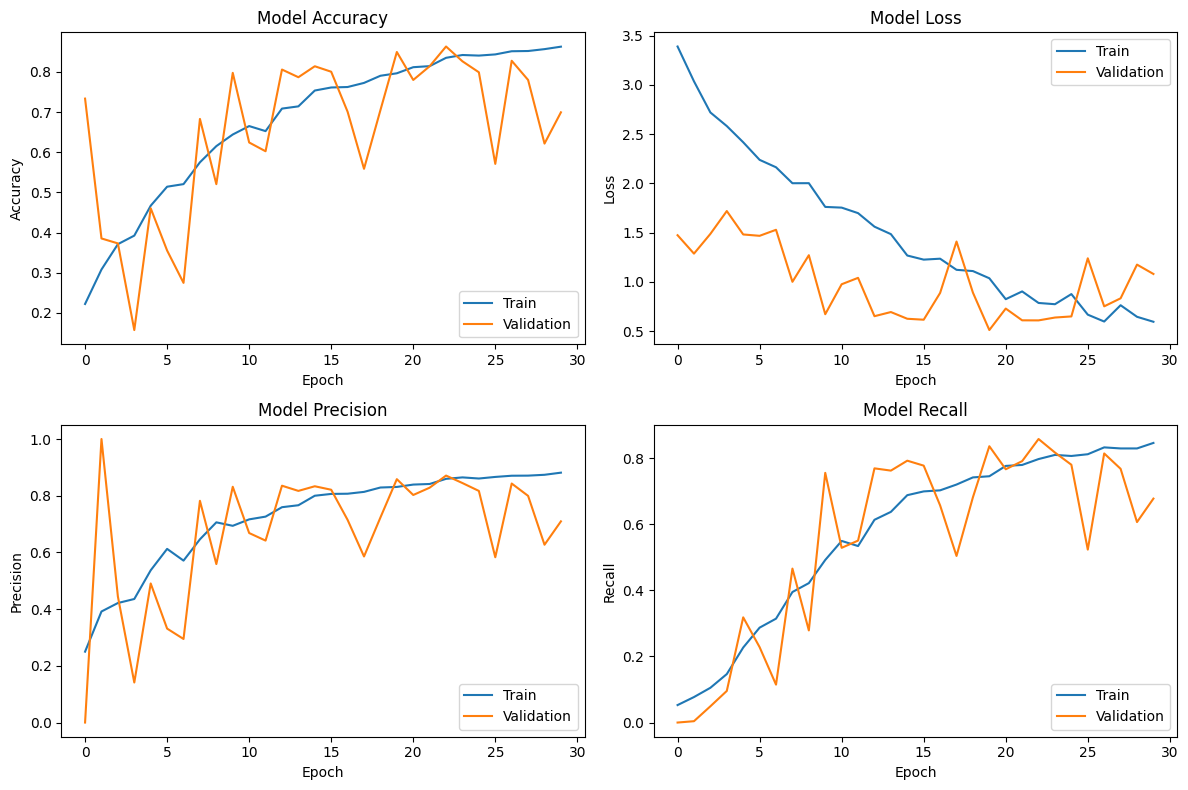

In [ ]:
# Plot training history
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.savefig('dr_training_history.png')
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step
Class 0: Sensitivity = 0.97, Specificity = 0.71
Class 1: Sensitivity = 0.07, Specificity = 1.00
Class 2: Sensitivity = 0.70, Specificity = 0.95
Class 3: Sensitivity = 0.69, Specificity = 0.99
Class 4: Sensitivity = 0.47, Specificity = 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       563
           1       0.60      0.07      0.13        41
           2       0.64      0.70      0.67        86
           3       0.47      0.69      0.56        13
           4       0.75      0.47      0.58        32

    accuracy                           0.86       735
   macro avg       0.68      0.58      0.58       735
weighted avg       0.85      0.86      0.84       735



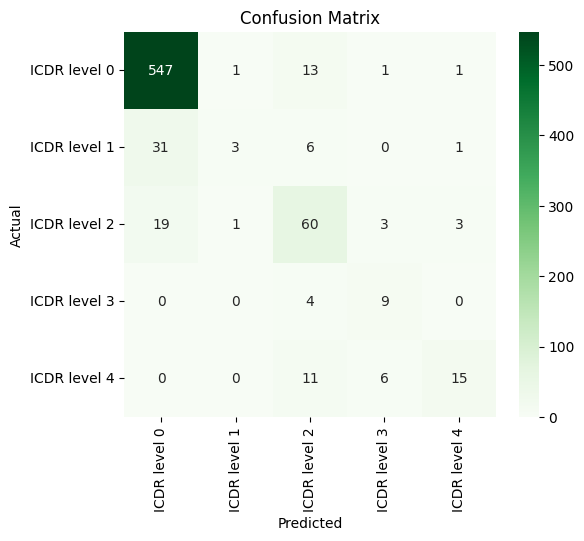

In [ ]:
best_model = tf.keras.models.load_model('rsg_net_V3drModel.h5')

y_true = test_generator.classes
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# confuion matrix
cm = confusion_matrix(y_true, y_pred)

# Determine sensitivity and specificity

sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = []
total_samples = cm.sum()
for i in range(len(cm)):
    tn = total_samples - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

for i in range(len(sensitivity)):
    print(f"Class {i}: Sensitivity = {sensitivity[i]:.2f}, Specificity = {specificity[i]:.2f}")

# classification report for performance metrics
print("\nClassification Report:\n", classification_report(y_true, y_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens", xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#load the best model
best_model = tf.keras.models.load_model('rsg_net_V3drModel.h5')

# Download the best model
files.download('rsg_net_V3drModel.h5')

# TFLite conversion of the best model
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the TFLite model
with open('rsg_net_V3drModel.tflite', 'wb') as f:
    f.write(tflite_model)

# Download the TFLite model
files.download('rsg_net_V3drModel.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved artifact at '/tmp/tmpt4r3ked5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137148060803216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137148060807248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137148060797648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137148060801680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137148060805904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137148060810512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137148060804368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137148060805328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137148060799376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137148060806480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1371480608074

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>